# Finite Volume Advection Equation
Solving $u_t+au_x = 0 $ using finite volumes with options for:
- first order upwind
- second order central upwind
- third order upwind
- flux limiting


In [106]:
import numpy as np
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.color_palette('colorblind')
from scipy import stats

In [130]:
def first_order_upwind(U, c, n, J):
    for j in range(J+1):
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if j < J:
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def second_order_upwind(U, c, n, J):
    for j in range(J+1):
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            flux_right = (min(c,0)*(U[n, j+1] + 0.5*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] + 0.5*(U[n, j+1] - U[n, j])))
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def third_order_upwind(U, c, n, J):
    eps = 10**-8
    def psi(theta): return 1/3 + (1/6)*theta
    for j in range(J+1):  
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])
        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right)

    return U

def flux_limited_upwind(U, c, n, J):
    eps = 10**-8
    def psi(theta): return max(0,min(1, 1/3 + (1/6)*theta, theta))
    for j in range(J+1):  
        if j==0:
            flux_left = 0
        else:
            flux_left = flux_right

        if 1 < j < J-1:
            theta = (U[n,j] - U[n,j-1]) / (U[n,j+1] - U[n,j] + eps) 
            flux_right = (min(c,0)*(U[n, j+1] + psi(1/(theta+eps))*(U[n, j] - U[n, j+1])) + max(c,0)*(U[n, j] +  psi(theta)*(U[n, j+1] - U[n, j])))
            
        elif j==J-1 or j==1: 
            flux_right = (min(c,0)*U[n, j+1] + max(c,0)*U[n, j])

        else:
            flux_right = 0

        U[n+1, j] = U[n,j] + (flux_left - flux_right) 

    return U

def solve_adv_eqn(solver=first_order_upwind, a=1, dt=0.001, dx=0.1, T_end=5, L=5,
                initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=0.2))):
    t = np.arange(0, T_end+dt, dt)
    x = np.arange(-L, L+dx , dx)

    N = len(t)-1
    J = len(x)-1
    U = np.zeros((N+1, J+1), dtype= float)

    U_0 = initial_dist(x) #Initial Conditions
    U[0,] = U_0
    c = a * (dt/dx)
    if abs(c)>1:
        warnings.warn('Method is likely to be unstable, CFL condition failed, c>1')
    for n in range(N):
        sol = solver(U, c, n, J)
    mass_loss =  (1 - sum(U[-1,:])/sum(U[0,:]))*100
    print('{} mass loss was {:.5f}%'.format(solver.__name__, mass_loss))
    return x, sol

first_order_upwind mass loss was -0.00000%
second_order_upwind mass loss was -0.00000%
third_order_upwind mass loss was 0.00000%
flux_limited_upwind mass loss was 0.00000%


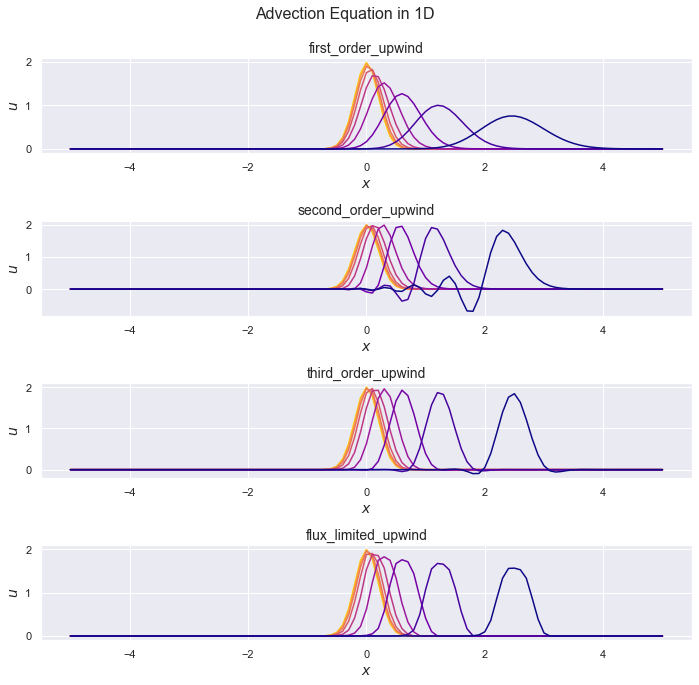

In [131]:
colormap = plt.get_cmap('plasma')
adv_solvers = [first_order_upwind, second_order_upwind, third_order_upwind, flux_limited_upwind]
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,10))
fig.suptitle('Advection Equation in 1D', fontsize=16)
def block(x): return np.array([int(i>=-0.5 and i<=0.5) for i in x])
for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = solve_adv_eqn(solver=solver, a=0.5, T_end=5, dx=0.1, dt=0.01)
    ax[idx].set_title(solver.__name__, fontsize=14)
    ax[idx].set_xlabel(r'$x$', fontsize=14)
    ax[idx].set_ylabel(r'$u$', fontsize=14)
    ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax[idx].plot(adv_x, adv_sol[int(i),])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
savepath = './'
plt.savefig(savepath+'{}.jpg'.format('upwind'), format='jpg', dpi=1000)
plt.show()


# Advection-Diffusion Equation
Add in a diffusive term, $\sigma \frac{\mathrm{d}^2 u}{\mathrm{d}x^2}$. Solve using Crank-Nicolson